In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### reading of data

In [92]:
### importing required packages
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from itertools import product
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [74]:
df = pd.read_csv('lung cancer survey.csv')
df_no_na = df.dropna()

df_age = df_no_na[df_no_na["AGE"] > 21]
# Use df_age for all models, where clustering algorithm models, such as Kmeans, randomforest, decision tree as they would have already categorise an age threshold within the model
df_age

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,0.0,61.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.0,59.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,54.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.0,54.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,1.0,62.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
8997,0.0,71.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
8998,1.0,63.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8999,1.0,70.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


## model training

### non-PCA

#### baseline model, k = 3

In [75]:
X = df_age[['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN']].values
y = df_age['LUNG_CANCER'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=888)

# Standardize the data (since KNN is sensitive to scale)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

k = 3  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Fit the model
knn_classifier.fit(X_train, y_train)

# Predict on the validation set
y_pred = knn_classifier.predict(X_val)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


KNeighborsClassifier(n_neighbors=3)

Accuracy: 0.8383
Precision: 0.8641
Recall: 0.9455
F1 Score: 0.9030


#### Hyperparameter tuning for k. Scoring = accuracy / f1 returns the same model.

In [4]:
# Create a pipeline to standardize the data and apply KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('knn', KNeighborsClassifier())  # KNN Classifier without setting neighbors yet
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}

# Define the custom K-Fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')

# Fit the GridSearchCV to find the best k
grid_search.fit(X_train, y_train)

# Get the best parameter for k
best_k = grid_search.best_params_['knn__n_neighbors']

# Retrieve best model
best_knn_classifier =  grid_search.best_estimator_

# Use best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Accuracy on validation set with k={best_k}: {accuracy:.4f}")
print(f"Precision on validation set with k={best_k}: {precision:.4f}")
print(f"Recall on validation set with k={best_k}: {recall:.4f}")
print(f"F1 Score on validation set with k={best_k}: {f1:.4f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='accuracy')

Optimal number of neighbors (k): 18
Accuracy on validation set with k=18: 0.8589
Precision on validation set with k=18: 0.8557
Recall on validation set with k=18: 0.9895
F1 Score on validation set with k=18: 0.9177


#### scoring = f1 returns a slightly different model

In [7]:
# Create a pipeline to standardize the data and apply KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('knn', KNeighborsClassifier())  # KNN Classifier without setting neighbors yet
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}

# Define the custom K-Fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1')

# Fit the GridSearchCV to find the best k
grid_search.fit(X_train, y_train)

# Get the best parameter for k
best_k = grid_search.best_params_['knn__n_neighbors']

# Retrieve best model
best_knn_classifier =  grid_search.best_estimator_

# Use best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Accuracy on validation set with k={best_k}: {accuracy:.4f}")
print(f"Precision on validation set with k={best_k}: {precision:.4f}")
print(f"Recall on validation set with k={best_k}: {recall:.4f}")
print(f"F1 Score on validation set with k={best_k}: {f1:.4f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='f1')

Optimal number of neighbors (k): 18
Accuracy on validation set with k=18: 0.8589
Precision on validation set with k=18: 0.8557
Recall on validation set with k=18: 0.9895
F1 Score on validation set with k=18: 0.9177


##### trying to maximise recall

In [5]:
# Create a pipeline to standardize the data and apply KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('knn', KNeighborsClassifier())  # KNN Classifier without setting neighbors yet
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}

# Define the custom K-Fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='recall')

# Fit the GridSearchCV to find the best k
grid_search.fit(X_train, y_train)

# Get the best parameter for k
best_k = grid_search.best_params_['knn__n_neighbors']

# Retrieve best model
best_knn_classifier =  grid_search.best_estimator_

# Use best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Accuracy on validation set with k={best_k}: {accuracy:.4f}")
print(f"Precision on validation set with k={best_k}: {precision:.4f}")
print(f"Recall on validation set with k={best_k}: {recall:.4f}")
print(f"F1 Score on validation set with k={best_k}: {f1:.4f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='recall')

Optimal number of neighbors (k): 19
Accuracy on validation set with k=19: 0.8556
Precision on validation set with k=19: 0.8509
Recall on validation set with k=19: 0.9923
F1 Score on validation set with k=19: 0.9162


### trying to incorporate PCA with KNNClassifier

#### adding PCA to the pipeline and searching PCA range from 1-14. Hyperparameter tuning of best k and PCA

#### as before, scoring = accuracy and f1 returns the same model. Only one is kept for conciseness

In [83]:
# Create a pipeline to standardize the data, apply PCA, and then KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()) 
])

param_grid = {
    'pca__n_components': list(range(1,15)), # search for best PC in the range 1 to 14
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}


kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters for k and number of components
best_k = grid_search.best_params_['knn__n_neighbors']
best_n_components = grid_search.best_params_['pca__n_components']

# Retrieve the best model
best_knn_classifier = grid_search.best_estimator_

# Use the best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Optimal number of PCA components: {best_n_components}")
print(f"Accuracy on validation set with k={best_k}, n_components={best_n_components}: {accuracy:.4f}")
print(f"Precision on validation set: {precision:.4f}")
print(f"Recall on validation set: {recall:.4f}")
print(f"F1 Score on validation set: {f1:.4f}")

C:\Users\drago\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14]},
             scoring='accuracy')

Optimal number of neighbors (k): 14
Optimal number of PCA components: 14
Accuracy on validation set with k=14, n_components=14: 0.8589
Precision on validation set: 0.8600
Recall on validation set: 0.9825
F1 Score on validation set: 0.9172


#### scoring = recall

In [70]:
# Create a pipeline to standardize the data, apply PCA, and then KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()) 
])

param_grid = {
    'pca__n_components': list(range(1,15)), # search for best PC in the range 1 to 14
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}


kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='recall')

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters for k and number of components
best_k = grid_search.best_params_['knn__n_neighbors']
best_n_components = grid_search.best_params_['pca__n_components']

# Retrieve the best model
best_knn_classifier = grid_search.best_estimator_

# Use the best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Optimal number of PCA components: {best_n_components}")
print(f"Accuracy on validation set with k={best_k}, n_components={best_n_components}: {accuracy:.4f}")
print(f"Precision on validation set: {precision:.4f}")
print(f"Recall on validation set: {recall:.4f}")
print(f"F1 Score on validation set: {f1:.4f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14]},
             scoring='recall')

Optimal number of neighbors (k): 19
Optimal number of PCA components: 1
Accuracy on validation set with k=19, n_components=1: 0.7956
Precision on validation set: 0.7959
Recall on validation set: 0.9993
F1 Score on validation set: 0.8861


#### Scree plot to view the drop in variance for each Scree Plot

<Axes: xlabel='Principal Component'>

Text(0.5, 1.0, 'Scree Plot (Percentage of Variation Explained)')

Text(0, 0.5, 'Percentage of Variation Explained (%)')

Text(0.5, 0, 'Principal Components')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'PC1'),
  Text(1, 0, 'PC2'),
  Text(2, 0, 'PC3'),
  Text(3, 0, 'PC4'),
  Text(4, 0, 'PC5'),
  Text(5, 0, 'PC6'),
  Text(6, 0, 'PC7'),
  Text(7, 0, 'PC8'),
  Text(8, 0, 'PC9'),
  Text(9, 0, 'PC10'),
  Text(10, 0, 'PC11'),
  Text(11, 0, 'PC12'),
  Text(12, 0, 'PC13'),
  Text(13, 0, 'PC14'),
  Text(14, 0, 'PC15')])

Text(0.45, -0.15, 'Figure. 1')

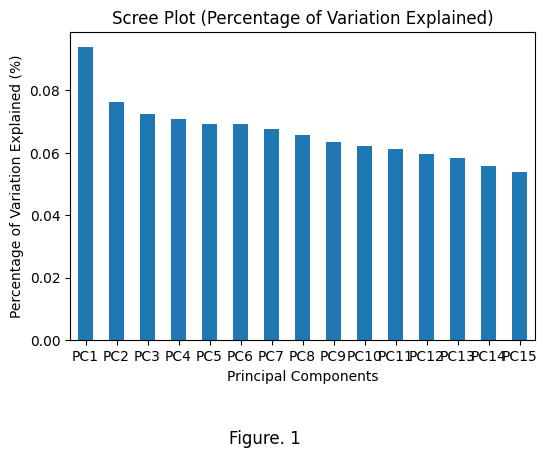

In [100]:
pca = PCA(n_components = 15)
principal_components = pca.fit_transform(X_train)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_# Create a DataFrame for Scree Plot
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio
})

# Plot the Scree Plot using Seaborn
explained_variance_df.plot(
    x='Principal Component',
    y='Explained Variance Ratio',
    kind='bar', 
    legend=False, 
    figsize=(6,4))
plt.title('Scree Plot (Percentage of Variation Explained)')
plt.ylabel('Percentage of Variation Explained (%)')
plt.xlabel('Principal Components')
plt.xticks(rotation=0)
plt.figtext(0.45, -0.15, "Figure. 1", ha="center", fontsize=12)
plt.show()

### including pairwise features

In [58]:
feature_names = [col for col in df_age.columns if col != "LUNG_CANCER"]

df_pairwise = df_age.copy()
# Generate all combinations of interaction terms for these features
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        new_column_name = f'{feature_names[i]}_{feature_names[j]}'
        df_pairwise[new_column_name] = df_pairwise[feature_names[i]] * df_pairwise[feature_names[j]]

df_pairwise

C:\Users\drago\AppData\Local\Temp\ipykernel_19108\655926420.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pairwise[new_column_name] = df_pairwise[feature_names[i]] * df_pairwise[feature_names[j]]
C:\Users\drago\AppData\Local\Temp\ipykernel_19108\655926420.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pairwise[new_column_name] = df_pairwise[feature_names[i]] * df_pairwise[feature_names[j]]
C:\Users\drago\AppData\Local\Temp\ipykernel_19108\655926420.py:8: PerformanceWarning: DataFrame is highly fragmented.  This 

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,...,ALCOHOL CONSUMING_COUGHING,ALCOHOL CONSUMING_SHORTNESS OF BREATH,ALCOHOL CONSUMING_SWALLOWING DIFFICULTY,ALCOHOL CONSUMING_CHEST PAIN,COUGHING_SHORTNESS OF BREATH,COUGHING_SWALLOWING DIFFICULTY,COUGHING_CHEST PAIN,SHORTNESS OF BREATH_SWALLOWING DIFFICULTY,SHORTNESS OF BREATH_CHEST PAIN,SWALLOWING DIFFICULTY_CHEST PAIN
0,0.0,61.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,59.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,54.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,54.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,1.0,62.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8997,0.0,71.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
8998,1.0,63.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8999,1.0,70.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
y = df_pairwise['LUNG_CANCER'].values
X = df_pairwise.drop("LUNG_CANCER", axis = 1).values

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=888)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

#### building baseline model, k =3

In [6]:
k = 3  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Fit the model
knn_classifier.fit(X_train, y_train)

# Predict on the validation set
y_pred = knn_classifier.predict(X_val)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


KNeighborsClassifier(n_neighbors=3)

Accuracy: 0.8311
Precision: 0.8677
Recall: 0.9295
F1 Score: 0.8975


#### Hyperparameter tuning for k. as before, when scoring = accuracy / f1, same model is returned

In [11]:
# Create a pipeline to standardize the data and apply KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('knn', KNeighborsClassifier())  # KNN Classifier without setting neighbors yet
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}

# Define the custom K-Fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')

# Fit the GridSearchCV to find the best k
grid_search.fit(X_train, y_train)

# Get the best parameter for k
best_k = grid_search.best_params_['knn__n_neighbors']

# Retrieve best model
best_knn_classifier =  grid_search.best_estimator_

# Use best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Accuracy on validation set with k={best_k}: {accuracy:.4f}")
print(f"Precision on validation set with k={best_k}: {precision:.4f}")
print(f"Recall on validation set with k={best_k}: {recall:.4f}")
print(f"F1 Score on validation set with k={best_k}: {f1:.4f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='accuracy')

Optimal number of neighbors (k): 20
Accuracy on validation set with k=20: 0.8622
Precision on validation set with k=20: 0.8650
Recall on validation set with k=20: 0.9797
F1 Score on validation set with k=20: 0.9188


#### scoring = f1

In [12]:
# Create a pipeline to standardize the data and apply KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('knn', KNeighborsClassifier())  # KNN Classifier without setting neighbors yet
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}

# Define the custom K-Fold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='recall')

# Fit the GridSearchCV to find the best k
grid_search.fit(X_train, y_train)

# Get the best parameter for k
best_k = grid_search.best_params_['knn__n_neighbors']

# Retrieve best model
best_knn_classifier =  grid_search.best_estimator_

# Use best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Accuracy on validation set with k={best_k}: {accuracy:.4f}")
print(f"Precision on validation set with k={best_k}: {precision:.4f}")
print(f"Recall on validation set with k={best_k}: {recall:.4f}")
print(f"F1 Score on validation set with k={best_k}: {f1:.4f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]},
             scoring='recall')

Optimal number of neighbors (k): 19
Accuracy on validation set with k=19: 0.8628
Precision on validation set with k=19: 0.8624
Recall on validation set with k=19: 0.9846
F1 Score on validation set with k=19: 0.9195


#### Trying Pairwise features with PCA

#### for this portion, we can see that the model does not improve from above. Pairwise features does not further improve the model when PCA is introduced

In [87]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()) 
])

param_grid = {
    'pca__n_components': list(range(1,15)),
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}


kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters for k and number of components
best_k = grid_search.best_params_['knn__n_neighbors']
best_n_components = grid_search.best_params_['pca__n_components']

# Retrieve the best model
best_knn_classifier = grid_search.best_estimator_

# Use the best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Optimal number of PCA components: {best_n_components}")
print(f"Accuracy on validation set with k={best_k}, n_components={best_n_components}: {accuracy:.4f}")
print(f"Precision on validation set: {precision:.4f}")
print(f"Recall on validation set: {recall:.4f}")
print(f"F1 Score on validation set: {f1:.4f}")

C:\Users\drago\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14]},
             scoring='accuracy')

Optimal number of neighbors (k): 14
Optimal number of PCA components: 14
Accuracy on validation set with k=14, n_components=14: 0.8589
Precision on validation set: 0.8600
Recall on validation set: 0.9825
F1 Score on validation set: 0.9172


In [88]:
# Create a pipeline to standardize the data, apply PCA, and then KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()) 
])

param_grid = {
    'pca__n_components': list(range(1,15)),
    'knn__n_neighbors': list(range(1, 21))  # Search for the best k in the range 1 to 20
}


kf = KFold(n_splits=5, shuffle=True, random_state=888)  # 5-fold CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='recall')

# Fit the GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters for k and number of components
best_k = grid_search.best_params_['knn__n_neighbors']
best_n_components = grid_search.best_params_['pca__n_components']

# Retrieve the best model
best_knn_classifier = grid_search.best_estimator_

# Use the best model to predict on the validation set
y_pred = best_knn_classifier.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Display the results
print(f"Optimal number of neighbors (k): {best_k}")
print(f"Optimal number of PCA components: {best_n_components}")
print(f"Accuracy on validation set with k={best_k}, n_components={best_n_components}: {accuracy:.4f}")
print(f"Precision on validation set: {precision:.4f}")
print(f"Recall on validation set: {recall:.4f}")
print(f"F1 Score on validation set: {f1:.4f}")

GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14]},
             scoring='recall')

Optimal number of neighbors (k): 19
Optimal number of PCA components: 1
Accuracy on validation set with k=19, n_components=1: 0.7956
Precision on validation set: 0.7959
Recall on validation set: 0.9993
F1 Score on validation set: 0.8861
